In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(tidyverse)

In [3]:
library(ggpubr)
library(ggplot2)

In [3]:
library(pheatmap)

In [1]:
load("temp.Rdata")

In [4]:
#load('../02.differential/Deseq2_TvsN_FC2.Rdata')

In [ ]:
rlt_high_tn$diff %>% filter(category=="tumor") %>% rownames() -> high_tspec_genes
rlt_low_tn$diff %>% filter(category=="tumor") %>% rownames() -> low_tspec_genes
rlt_neg_tn$diff %>% filter(category=="tumor") %>% rownames() -> neg_tspec_genes

In [ ]:
rlt_high_tn$diff %>% filter(category=="normal") %>% rownames() -> high_nspec_genes
rlt_low_tn$diff %>% filter(category=="normal") %>% rownames() -> low_nspec_genes
rlt_neg_tn$diff %>% filter(category=="normal") %>% rownames() -> neg_nspec_genes

In [7]:
DoGO <- function(gene){
    gene_id <- bitr(gene,fromType = "ALIAS",toType="ENTREZID", OrgDb="org.Hs.eg.db")
    data_go <- enrichGO(gene = 
                             gene_id$ENTREZID,
                             OrgDb = org.Hs.eg.db,
                             ont = "All",
                             pAdjustMethod = "BH",
                             qvalueCutoff = 0.05,
                            pvalueCutoff = 0.05,
                             readable = TRUE
                        )
    return(data_go)
}

In [8]:
DoGO2 <- function(gene){
    gene_id <- bitr(gene,fromType = "ALIAS",toType="ENTREZID", OrgDb="org.Hs.eg.db")
    data_go <- enrichGO(gene = 
                             gene_id$ENTREZID,
                             OrgDb = org.Hs.eg.db,
                             ont = "All",
                             pAdjustMethod = "BH",
                             qvalueCutoff = 1,
                            pvalueCutoff = 1,
                             readable = TRUE
                        )
    return(data_go)
}

In [ ]:
High_tumor_go <- DoGO(high_tspec_genes)
Low_tumor_go <- DoGO(low_tspec_genes)
Neg_tumor_go <- DoGO(neg_tspec_genes)

In [ ]:
High_normal_go <- DoGO(high_nspec_genes)
Low_normal_go <- DoGO(low_nspec_genes)
Neg_normal_go <- DoGO(neg_nspec_genes)

In [ ]:
High_tumor_go_all <- DoGO2(high_tspec_genes)
Low_tumor_go_all <- DoGO2(low_tspec_genes)
Neg_tumor_go_all <- DoGO2(neg_tspec_genes)

In [13]:
High_tumor_go_all@result %>% as.data.frame() %>% saveRDS(object = .,file = "All.GO.Rdata")

In [18]:
p_go_high_t <- dotplot(High_tumor_go,showCategory = 15)
p_go_low_t <-dotplot(Low_tumor_go,showCategory = 15)
p_go_neg_t <- dotplot(Neg_tumor_go,showCategory = 20)

In [19]:
p_go_high_n <- dotplot(High_normal_go,showCategory = 15)
p_go_low_n <-dotplot(Low_normal_go,showCategory = 15)
p_go_neg_n <- dotplot(Neg_normal_go,showCategory = 20)

In [20]:
openxlsx::write.xlsx(list('High_InTumor' = High_tumor_go@result,'High_InNormal' = High_normal_go@result,
                'Low_InTumor' = Low_tumor_go@result,'Low_InNormal' = Low_normal_go@result,
                'Neg_InTumor' = Neg_tumor_go@result, 'Neg_InNormal' = Neg_normal_go@result), 
           rowNames = TRUE, file = "GO_Tumor_vs_Normal.FC2.xlsx")

In [23]:
options(repr.plot.height=4,repr.plot.width=16)
p_go_t <- ggarrange(p_go_high_t,p_go_low_t,p_go_neg_t,ncol = 3,
                       labels = c("High","Low","Neg"))

In [ ]:
options(repr.plot.height=10,repr.plot.width=16)
p_go_t

In [25]:
ggsave(filename = "GO_T_vs_N.FC2.pdf",plot = p_go_t,width = 16,height = 8)

### barplot

In [11]:
high_top15_go <- High_tumor_go@result$ID %>% head(n = 15)
low_top15_go <-Low_tumor_go@result$ID %>% head(n = 15)
neg_top15_go <-Neg_tumor_go@result$ID %>% head(n = 15)

In [13]:
unique(c(high_top15_go,low_top15_go,neg_top15_go)) -> top15_go_id

In [14]:
High_tumor_go2 <- High_tumor_go_all@result[top15_go_id,]
Low_tumor_go2 <- Low_tumor_go_all@result[top15_go_id,]
Neg_tumor_go2 <- Neg_tumor_go_all@result[top15_go_id,]

In [15]:
High_tumor_go2$padj <- -log10(High_tumor_go2$p.adjust)
Low_tumor_go2$padj <- -log10(Low_tumor_go2$p.adjust)
Neg_tumor_go2$padj <- -log10(Neg_tumor_go2$p.adjust)

In [16]:
High_tumor_go2$Description <- factor(High_tumor_go2$Description,levels = rev(High_tumor_go2$Description))
Low_tumor_go2$Description <- factor(Low_tumor_go2$Description,levels = rev(Low_tumor_go2$Description))
Neg_tumor_go2$Description <- factor(Neg_tumor_go2$Description,levels = rev(Neg_tumor_go2$Description))

In [130]:
openxlsx::write.xlsx(list('High' =  High_tumor_go@result,
                          'Low' = Low_tumor_go@result,
                          'Neg' = Neg_tumor_go@result),
           rowNames = TRUE, file = "GO_TumorvsNormal.FC2.xlsx")

In [28]:
rlt_exclusive <- as.data.frame(matrix(data = NA,nrow = 20,ncol = 4))
for(i in 1:32){
    high_temp <- High_tumor_go2$geneID[i] %>% str_split("/") %>% .[[1]]
    low_temp <- Low_tumor_go2$geneID[i] %>% str_split("/") %>% .[[1]]
    neg_temp <- Neg_tumor_go2$geneID[i] %>% str_split("/") %>% .[[1]]
    high_spec <- setdiff(high_temp,low_temp) %>% setdiff(neg_temp)
    low_spec <- setdiff(low_temp,neg_temp) %>% setdiff(high_temp)
    neg_spec <- setdiff(neg_temp,low_temp) %>% setdiff(high_temp)
    high_spec2 <- paste0(high_spec,collapse = ",")
    low_spec2 <- paste0(low_spec,collapse = ",")
    neg_spec2 <- paste0(neg_spec,collapse = ",")
    rlt_exclusive[i,1] <- High_tumor_go2$Description[i] %>% as.character()
    rlt_exclusive[i,2] <- high_spec2
    rlt_exclusive[i,3] <- low_spec2
    rlt_exclusive[i,4] <- neg_spec2
}

In [29]:
rlt_exclusive %>% dim()

[1] 32  4

In [30]:
colnames(rlt_exclusive) <- c("Name","high","low","neg")

In [31]:
openxlsx::write.xlsx(rlt_exclusive,rowNames = FALSE, file = "GO_top15_exclusive.FC2.xlsx")

In [34]:
p_high_go_top20 <- ggplot(data=High_tumor_go2,aes(x =Description ,y = padj))+geom_col(fill="#d22c27",width=0.85) + 
    theme_bw()+coord_flip()+xlab('')+theme(axis.text.y = element_text(color = "black"))+
    geom_hline(yintercept=-log10(0.01),linetype = "dashed")

In [35]:
p_low_go_top20 <- ggplot(data=Low_tumor_go2,aes(x =Description ,y = padj))+geom_col(fill="#67b045",width=0.85) + 
    theme_bw()+coord_flip()+xlab('')+theme(axis.text.y = element_text(color = "black"))+
    geom_hline(yintercept=-log10(0.01),linetype = "dashed")

In [36]:
p_neg_go_top20 <- ggplot(data=Neg_tumor_go2,aes(x =Description ,y = padj))+geom_col(fill="#0785a3",width=0.85) + 
    theme_bw()+coord_flip()+xlab('')+theme(axis.text.y = element_text(color = "black"))+
    geom_hline(yintercept=-log10(0.01),linetype = "dashed")

In [37]:
p_go_top20 <- ggarrange(p_high_go_top20,p_low_go_top20,p_neg_go_top20,ncol=3,nrow=1,
          labels = c("High_tumor","Low_tumor","Neg_tumor"))

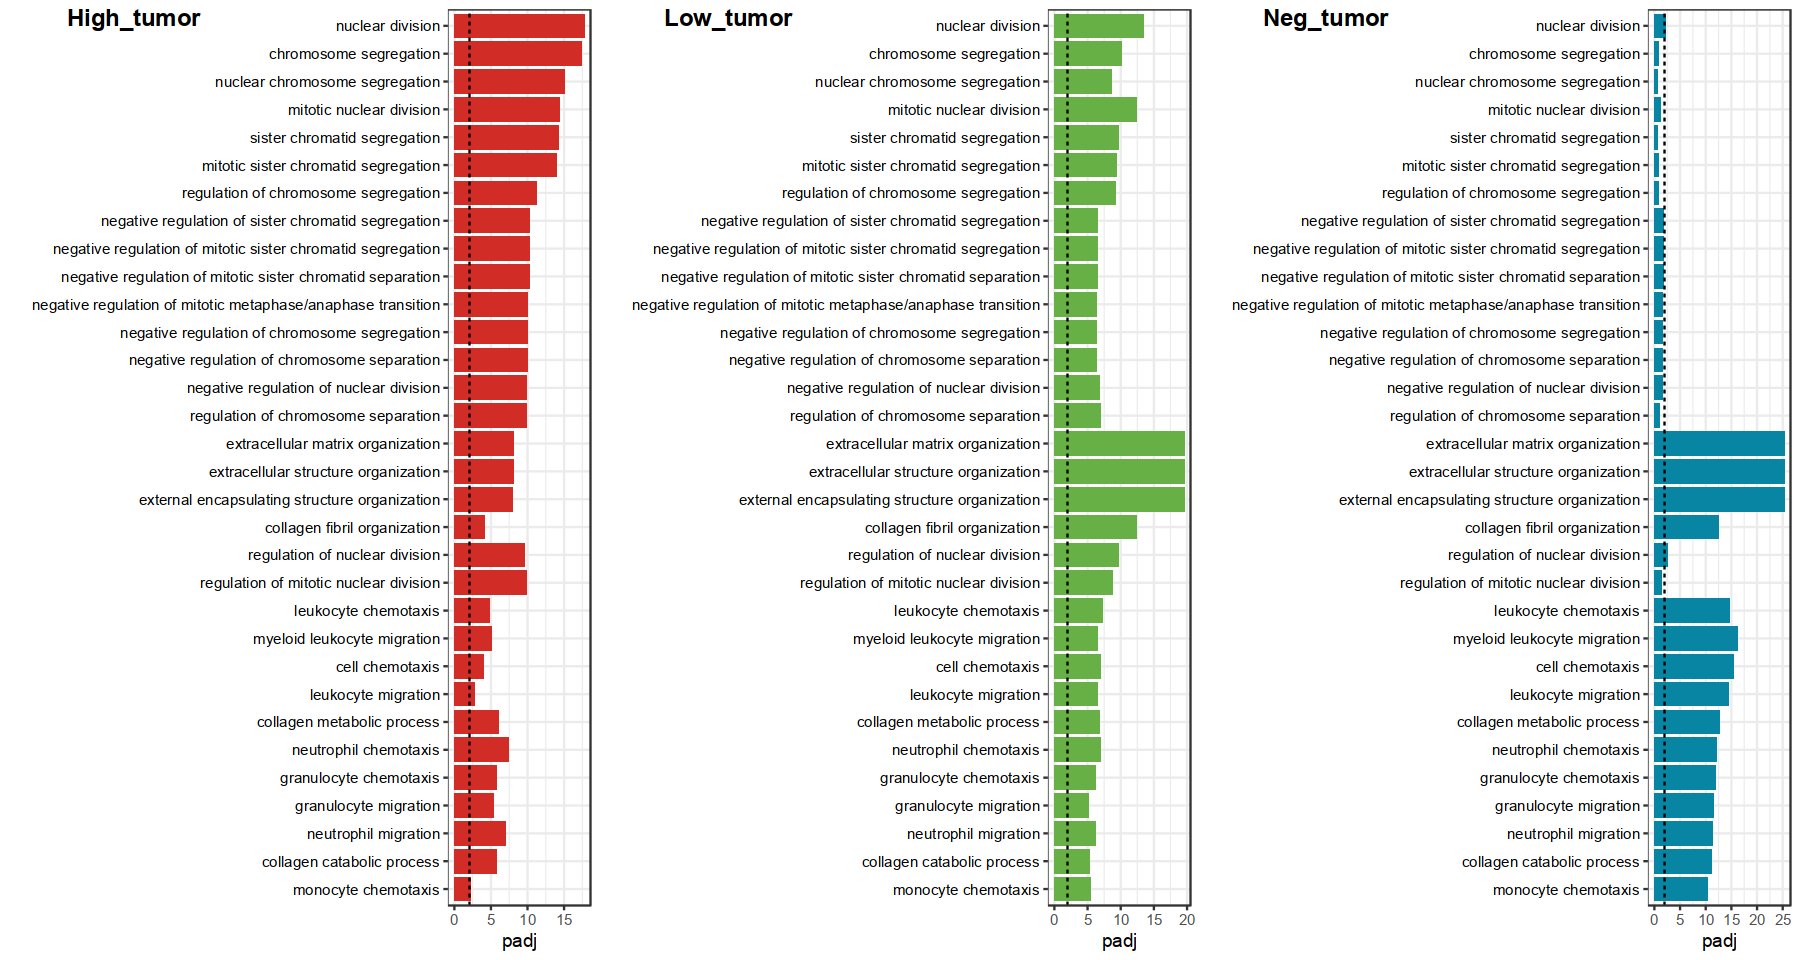

In [9]:
options(repr.plot.height=8,repr.plot.width=15)
p_go_top20

In [39]:
ggsave(filename = "GO.Top15ForEach.FC2.pdf",plot = p_go_top20,width = 15,height = 5)

In [48]:
GOheatmap <- function(type){
    temp1 <- High_tumor_go@result %>% filter(p.adjust<0.05)%>% filter( str_detect(Description,type))
    temp2 <- Low_tumor_go@result %>% filter(p.adjust<0.05)%>% filter( str_detect(Description,type))
    temp3 <- Neg_tumor_go@result %>% filter(p.adjust<0.05)%>% filter( str_detect(Description,type))
    all_terms <- unique(c(temp1$Description,temp2$Description,temp3$Description))
    
    go_heatmap <- matrix(0,nrow = length(unique(all_terms)),ncol=3)
    go_heatmap <- as.data.frame(go_heatmap)
    rownames(go_heatmap) <- unique(all_terms)
    colnames(go_heatmap)<- c('High',"Low","Neg")
    
    temp1$padj <- -log10(temp1$p.adjust)
    go_heatmap[match(temp1$Description,rownames(go_heatmap)),1]  = temp1$padj
    
    temp2$padj <- -log10(temp2$p.adjust)
    go_heatmap[match(temp2$Description,rownames(go_heatmap)),2]  = temp2$padj
    
    temp3$padj <- -log10(temp3$p.adjust)
    go_heatmap[match(temp3$Description,rownames(go_heatmap)),3]  = temp3$padj

    go_heatmap[rowSums(go_heatmap) != 0 ,] -> go_heatmap
    return(go_heatmap)
}

In [108]:
heatmap_infla <- GOheatmap('inflammatory')
heatmap_cell_cycle <- GOheatmap('cell cycle')
heatmap_repair <- GOheatmap('repair')
heatmap_MHC <- GOheatmap('MHC class')


In [32]:
save.image("temp.Rdata")

In [63]:
#load("temp.Rdata")

In [125]:
options(repr.plot.height=8,repr.plot.width=5)
pheatmap(heatmap_infla,cluster_cols = F,color =colorRampPalette(c("white","#9A001E"))(50),
          height = 8,width = 5,filename = "GO_inflammatory_T_vs_N.heatmap.FC2.pdf")

In [123]:
options(repr.plot.height=8,repr.plot.width=6.5)
pheatmap(heatmap_cell_cycle,cluster_cols = F,color =colorRampPalette(c("white","#9A001E"))(50),
          height = 8,width = 6.5,filename = "GO_cellcycle_T_vs_N.heatmap.FC2.pdf")

In [121]:
options(repr.plot.height=4,repr.plot.width=5)
pheatmap(heatmap_repair,cluster_cols = F,color =colorRampPalette(c("white","#9A001E"))(50),
        height = 3,width = 6.5,filename = "GO_repair_T_vs_N.heatmap.FC2.pdf")

In [120]:
options(repr.plot.height=4,repr.plot.width=5)
pheatmap(heatmap_MHC,cluster_cols = F,color =colorRampPalette(c("white","#9A001E"))(50),
         height = 5,width = 8,filename = "GO_MHC_T_vs_N.heatmap.FC2.pdf")

In [116]:
extract_gene <- function(heatmap_file){
    inflammation_gene <- matrix(data = NA,nrow = nrow(heatmap_file),ncol=ncol(heatmap_file))
    rownames(inflammation_gene) <- rownames(heatmap_file)
    colnames(inflammation_gene) <- c("High","Low","Neg")
    for(each in rownames(heatmap_file)){
        high = High_tumor_go@result %>% filter(Description ==each) %>% as.data.frame() %>% .[,9]
        if(length(high)>0){
           high <- high %>% str_split('/')%>% .[[1]]
        }
        low = Low_tumor_go@result %>% filter(Description ==each) %>% as.data.frame() %>% .[,9] 
        if(length(low)>0){
           low <- low %>% str_split('/')%>% .[[1]]
        }
        neg = Neg_tumor_go@result %>% filter(Description ==each) %>% as.data.frame() %>% .[,9] 
        if(length(neg)>0){
           neg <- neg %>% str_split('/')%>% .[[1]]
        }
        high_spec = setdiff(high,low) %>% setdiff(.,neg)%>% paste( collapse = ', ')
        low_spec = setdiff(low,high) %>% setdiff(.,neg)%>% paste( collapse = ', ')
        neg_spec = setdiff(neg,high) %>% setdiff(.,low)%>% paste( collapse = ', ')
        inflammation_gene[each,'High']  = high_spec
        inflammation_gene[each,'Low']  = low_spec
        inflammation_gene[each,'Neg']  = neg_spec
    }
    return(inflammation_gene)
}


In [117]:
infla_gene <- extract_gene(heatmap_infla)

In [118]:
cellcycle_gene <- extract_gene(heatmap_cell_cycle)

In [119]:
repair_gene <- extract_gene(heatmap_repair)

In [120]:
MHC_gene <- extract_gene(heatmap_MHC)

In [127]:
openxlsx::write.xlsx(list('Inflammation' =infla_gene,'CellCycle' = cellcycle_gene,"DNArepair" = repair_gene,
                'MHC' = MHC_gene), rowNames = TRUE, file = "Exclusive_Genes.GO.xlsx")